In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import gdal
import nivapy3 as nivapy
import seaborn as sn
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from pprint import pprint
from skimage import exposure
from skimage.util import img_as_ubyte
from joblib import dump, load

sn.set(style="ticks")
plt.style.use('ggplot')

In [2]:
def image_to_sample_df(area, equalise=False, dropna=True):
    """
    """
    # Containers for data
    data_dict = {}
    data_dict['y'] = []
    for band in range(1, 9):
        data_dict[str(band)] = []

    # Paths to images
    raw_path = f'/home/jovyan/shared/drones/frisk_oslofjord/raster/ne_akeroya_5cm_area_{area}.tif'
    man_path = f'/home/jovyan/shared/drones/frisk_oslofjord/raster/ne_akeroya_5cm_area_{area}_man_class.tif'

    # Read raw bands to arrays
    for band in range(1, 9):
        data, ndv, epsg, extent = nivapy.spatial.read_raster(raw_path, band_no=band)
        
        if equalise:
            data = img_as_ubyte(exposure.equalize_hist(data))
            
        data_dict[str(band)].append(data.flatten())

    # Read manually classified data (1 band only)
    man_img, ndv, man_epsg, extent = nivapy.spatial.read_raster(man_path, band_no=1)
    data_dict['y'].append(man_img.flatten())

    # Concatenate to single dataset
    data_dict['y'] = np.concatenate(data_dict['y'])
    for band in range(1, 9):
        data_dict[str(band)] = np.concatenate(data_dict[str(band)])

    # Build df
    df = pd.DataFrame(data_dict)
    del(data_dict)

    # Remove NoData and Other
    if dropna:
        df = df.query('y > 0')
        
    df.reset_index(inplace=True, drop=True)
    
    return df

def classification_report(truths, preds, class_labels, class_names):
    """
    """
    print("Classification report:\n%s" %
          metrics.classification_report(truths,
                                        preds, 
                                        labels=class_labels, 
                                        target_names=class_names,
                                       ),
         )

    print("Classification accuracy: %f" %
          metrics.accuracy_score(truths, 
                                 preds,
                                ),
         )

## 1. Image "equalisation"

### 1.1. Histograms

In [3]:
# Area of interest
area = 2 

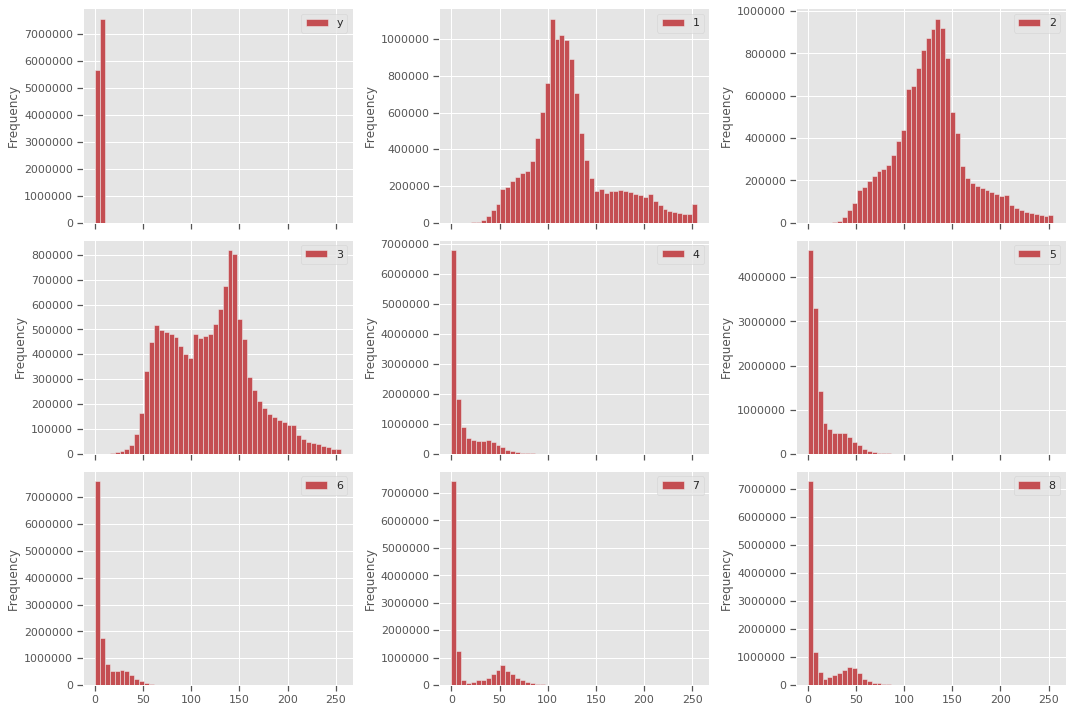

In [4]:
# Without equalisation
df_noeq = image_to_sample_df(area, equalise=False)

df_noeq.plot.hist(bins=50, 
                  layout=(3,3), 
                  subplots=True, 
                  figsize=(15,10),
                  color='r'
                 )

plt.tight_layout()

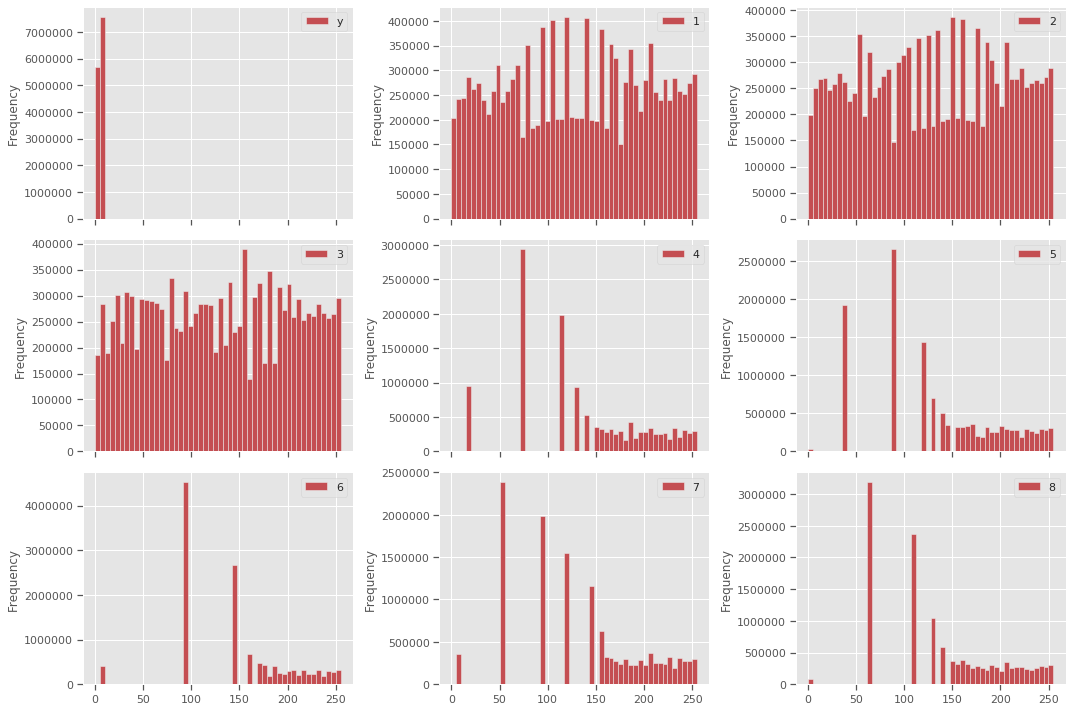

In [5]:
# With equalisation
df_eq = image_to_sample_df(area, equalise=True)

df_eq.plot.hist(bins=50, 
                layout=(3,3), 
                subplots=True, 
                figsize=(15,10),
                color='r'
               )

plt.tight_layout()

### 1.2. RGB image appearance

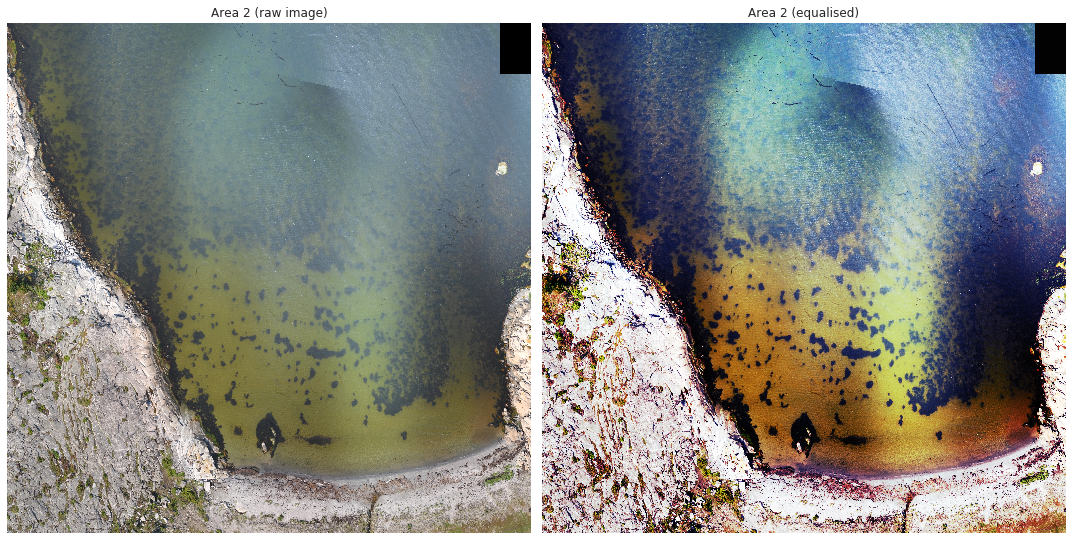

In [6]:
# Path to image
raw_path = f'/home/jovyan/shared/drones/frisk_oslofjord/raster/ne_akeroya_5cm_area_{area}.tif'

# Read raw RGB bands to arrays
band1, ndv, epsg, extent = nivapy.spatial.read_raster(raw_path, band_no=1)
band2, ndv, epsg, extent = nivapy.spatial.read_raster(raw_path, band_no=2)
band3, ndv, epsg, extent = nivapy.spatial.read_raster(raw_path, band_no=3)

# Equalise RGB
band1_eq = img_as_ubyte(exposure.equalize_hist(band1))
band2_eq = img_as_ubyte(exposure.equalize_hist(band2))
band3_eq = img_as_ubyte(exposure.equalize_hist(band3))

raw_img = np.dstack((band1, band2, band3))
raw_img_eq = np.dstack((band1_eq, band2_eq, band3_eq))

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,8))

# Raw image
axes[0].imshow(raw_img)
axes[0].set_title(f'Area {area} (raw image)', fontsize=12)

# Manually classified
axes[1].imshow(raw_img_eq)
axes[1].set_title(f'Area {area} (equalised)', fontsize=12)

# Turn off axes
axes[0].axis('off')
axes[1].axis('off')

plt.tight_layout()

## 2. Rasterise vector training data

Note that the `Eelgrass` and `Lichen (2)` classes were not used when digitising, as I was unable to separate them from the other categories.

In [7]:
# Class codes
class_codes = {-1:'Other',
               0: 'No data',
               1: 'Brown algae',
               2: 'Green algae',
               3: 'Red algae', 
               4: 'Eelgrass',
               5: 'Rock',
               6: 'Sand',
               7: 'Lichen',
               8: 'Lichen (2)',
               9: 'Terrestrial vegetation',
               10:'Beach/shingle',
              }

# Loop over shapefiles
for area in range(1, 7):
    # Path rasters
    snap_tif = f'/home/jovyan/shared/drones/frisk_oslofjord/raster/ne_akeroya_5cm_area_{area}.tif'
    shp_path = f'/home/jovyan/shared/drones/frisk_oslofjord/vector/area_{area}_classes.shp'
    tif_path = f'/home/jovyan/shared/drones/frisk_oslofjord/raster/ne_akeroya_5cm_area_{area}_man_class.tif'
    
    # Rasterise
    nivapy.spatial.shp_to_ras(shp_path, 
                              tif_path, 
                              snap_tif, 
                              'substrate', 
                              0, 
                              gdal.GDT_Int16,
                             )

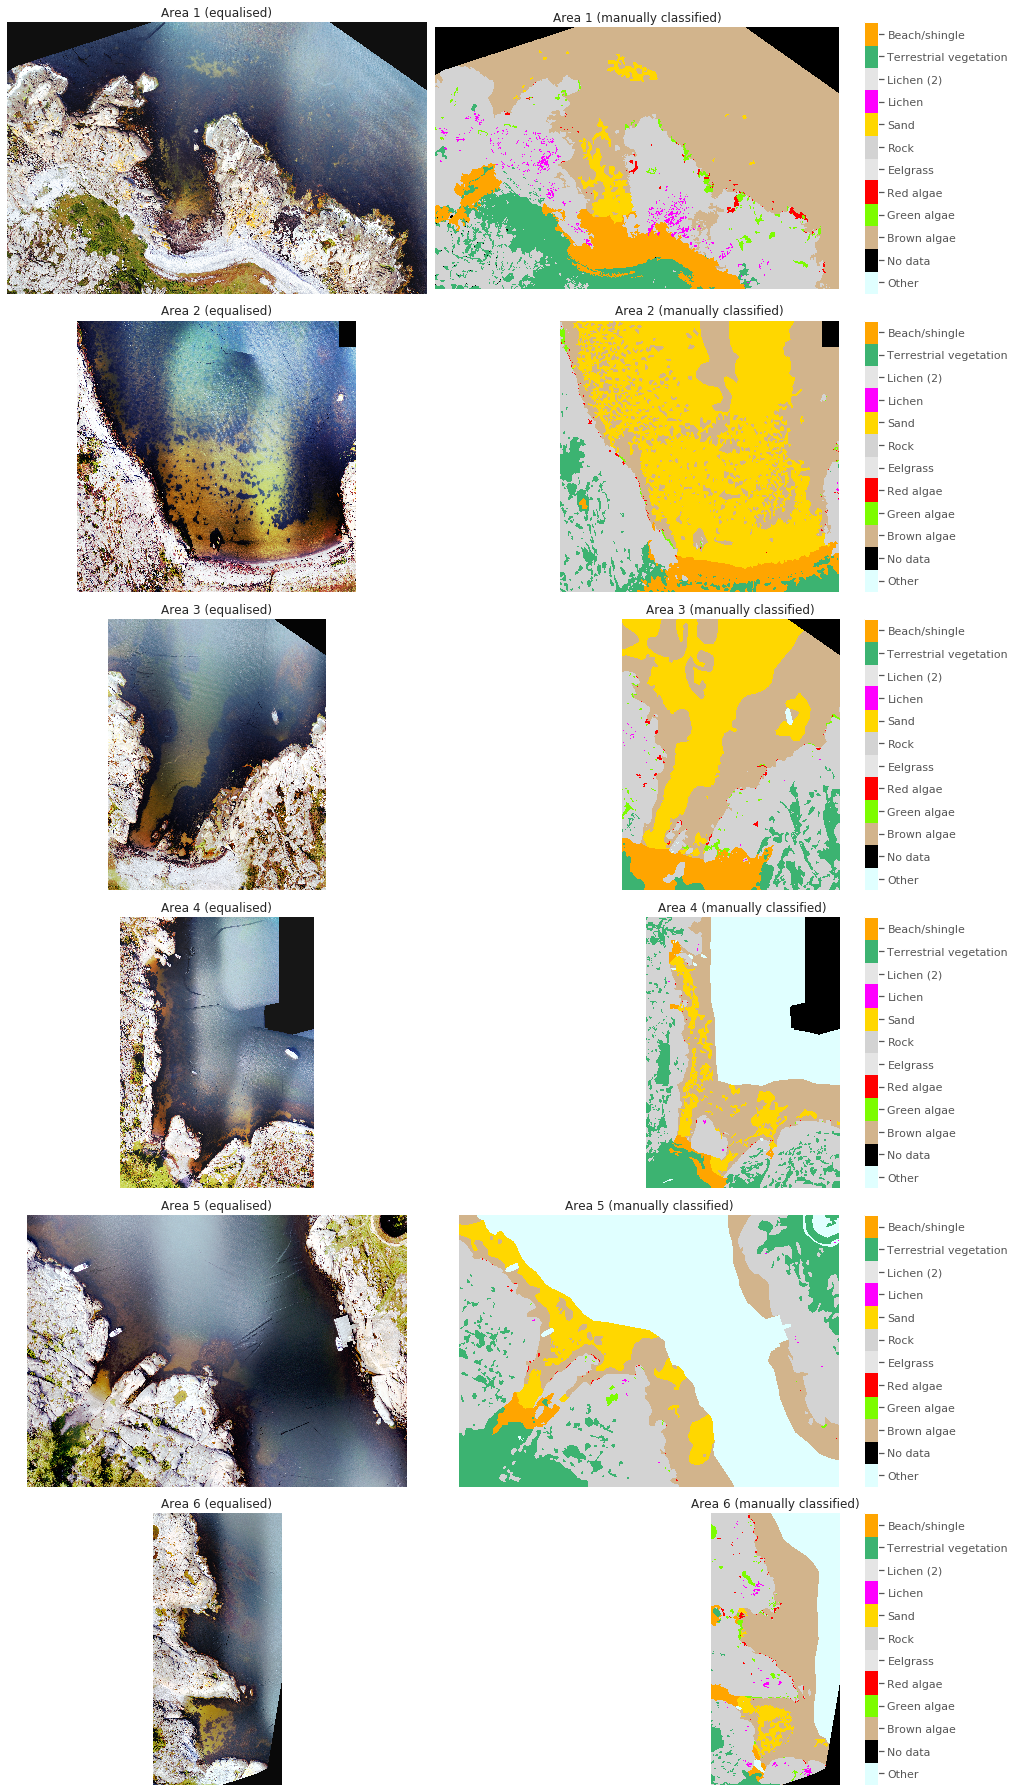

In [8]:
# Setup plot
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(15,25))

# Define colours for classes. Same order as in 'class_codes'
cmap = colors.ListedColormap(['lightcyan', 'black', 'tan', 'lawngreen', 'red', 'none',
                              'lightgrey', 'gold', 'magenta', 'none', 'mediumseagreen', 
                              'orange'])
bounds = np.arange(-1.5, 11.5)
norm = colors.BoundaryNorm(bounds, cmap.N)

# Loop over data
for area in range(1, 7):
    idx = area - 1
    
    # Paths to images
    raw_path = f'/home/jovyan/shared/drones/frisk_oslofjord/raster/ne_akeroya_5cm_area_{area}.tif'
    man_path = f'/home/jovyan/shared/drones/frisk_oslofjord/raster/ne_akeroya_5cm_area_{area}_man_class.tif'
    
    # Read raw RGB bands to arrays
    band1, ndv, epsg, extent = nivapy.spatial.read_raster(raw_path, band_no=1)
    band2, ndv, epsg, extent = nivapy.spatial.read_raster(raw_path, band_no=2)
    band3, ndv, epsg, extent = nivapy.spatial.read_raster(raw_path, band_no=3)
    
    # Equalise images
    band1 = img_as_ubyte(exposure.equalize_hist(band1))
    band2 = img_as_ubyte(exposure.equalize_hist(band2))
    band3 = img_as_ubyte(exposure.equalize_hist(band3))
    
    raw_img = np.dstack((band1, band2, band3))
    
    # Read manually classified data (1 band only)
    man_img, ndv, man_epsg, extent = nivapy.spatial.read_raster(man_path, band_no=1)
    
    # Plot
    # Raw image
    axes[idx, 0].imshow(raw_img)
    axes[idx, 0].set_title(f'Area {area} (equalised)', fontsize=12)
    
    # Manually classified
    img = axes[idx, 1].imshow(man_img, cmap=cmap, norm=norm)
    axes[idx, 1].set_title(f'Area {area} (manually classified)', fontsize=12)
    
    # Turn off axes
    axes[idx, 0].axis('off')
    axes[idx, 1].axis('off')
    
    # Colourbar for manual dataset
    cb = plt.colorbar(img, ax=axes[idx, 1])    
    labels = np.arange(-1, 11)
    cb.set_ticks(labels)
    cb.set_ticklabels(list(class_codes.values()))
    
plt.tight_layout()

## 3. Training on a single image

### 3.1. Get samples dataframe

In [9]:
# Area of interest
area = 1

# With equalisation
df = image_to_sample_df(area, equalise=False)

# Split into training and evaluation
cols = [str(i) for i in range(1, 9)]
X_train, X_eval, y_train, y_eval = train_test_split(df[cols],
                                                    df['y'],
                                                    test_size=0.4,
                                                    random_state=42,
                                                   )

# Checking
assert len(X_train) == len(y_train)
assert len(X_eval) == len(y_eval)
print('Number of training samples:  ', len(X_train))
print('Number of evaluation samples:', len(X_eval))

df.head()

Number of training samples:   4217199
Number of evaluation samples: 2811467


y   1    2    3  4  5  6  7  8
0  1  80  106  121  2  3  3  4  2
1  1  81  108  123  2  3  3  4  2
2  1  76  101  116  2  3  3  4  2
3  1  81  105  121  2  3  3  4  2
4  1  81  105  120  2  3  3  4  2

### 3.2. Evaluate "basic" classifier

In [10]:
%%time
base_model = RandomForestClassifier(n_estimators=10, 
                                    max_depth=20,
                                    random_state=42, 
                                    n_jobs=-1,
                                   )
base_model.fit(X_train, y_train)

CPU times: user 4min 36s, sys: 2.6 s, total: 4min 39s
Wall time: 53.5 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [11]:
%%time

# Predict classes for remaining 40% of data
base_preds = base_model.predict(X_eval)

CPU times: user 12.7 s, sys: 838 ms, total: 13.6 s
Wall time: 2.87 s


In [12]:
# Only use relevant labels from the training dataset
class_labels = [1, 2, 3, 5, 6, 7, 9, 10]
class_names = [class_codes[i] for i in class_labels]

classification_report(y_eval, 
                      base_preds, 
                      class_labels, 
                      class_names,
                     )

Classification report:
                        precision    recall  f1-score   support

           Brown algae       0.98      0.97      0.98   1251654
           Green algae       0.79      0.56      0.66     21688
             Red algae       0.77      0.42      0.54     10113
                  Rock       0.91      0.96      0.94    962213
                  Sand       0.85      0.81      0.83     72495
                Lichen       0.82      0.65      0.73     27937
Terrestrial vegetation       0.94      0.92      0.93    252276
         Beach/shingle       0.91      0.83      0.87    213091

              accuracy                           0.94   2811467
             macro avg       0.87      0.77      0.81   2811467
          weighted avg       0.94      0.94      0.94   2811467

Classification accuracy: 0.941333


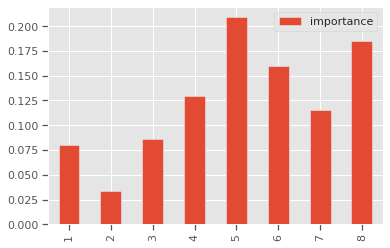

In [13]:
# Feature importances
imp_df = pd.DataFrame({'importance':base_model.feature_importances_},
                      index=range(1, 9),
                     )
imp_df.plot.bar()

### 3.3. Hyperparameter tuning

In [14]:
## Number of trees in random forest
#n_estimators = 100
#
## Number of features to consider at every split
#max_features = ['auto', 'sqrt']
#
## Maximum number of levels in tree
#max_depth = [int(x) for x in np.linspace(10, 100, num=4)]
#max_depth.append(None)
#
## Create the random grid
#random_grid = {'max_features': max_features,
#               'max_depth': max_depth,
#              }
#
#pprint(random_grid)

In [15]:
#%%time
## Use the random grid to search for best hyperparameters
## First create the base model to tune
#rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
#
## Random search of parameters, using 3 fold cross validation, 
## search across 100 different combinations, and use all available cores
#rf_random = RandomizedSearchCV(estimator=rf,
#                               param_distributions=random_grid, 
#                               n_iter=100,
#                               cv=3,
#                               verbose=2,
#                               random_state=42,
#                               n_jobs=-1,
#                              )
#
## Fit the random search model
#rf_random.fit(X_train, y_train)

In [16]:
#%%time
#
#best = rf_random.best_estimator_
#
## Predict classes for remaining 40% of data
#best_preds = best.predict(X_eval)

In [17]:
#classification_report(y_eval, 
#                      best_preds, 
#                      class_labels, 
#                      class_names,
#                     )

## 4. Train "basic" model using images 1, 2 and 6

In [18]:
# Read image data
df_list = []
for area in [1, 2, 6]:
    # With equalisation
    df = image_to_sample_df(area, equalise=False)
    df_list.append(df)
    
df = pd.concat(df_list, axis='rows')
del df_list

print('Number of training samples:  ', len(df))

df.head()

Number of training samples:   25039284


y   1    2    3  4  5  6  7  8
0  1  80  106  121  2  3  3  4  2
1  1  81  108  123  2  3  3  4  2
2  1  76  101  116  2  3  3  4  2
3  1  81  105  121  2  3  3  4  2
4  1  81  105  120  2  3  3  4  2

In [19]:
%%time
# Train basic model
base_model = RandomForestClassifier(n_estimators=10, 
                                    max_depth=20,
                                    random_state=42, 
                                    n_jobs=-1,
                                   )

cols = [str(i) for i in range(1, 9)]
base_model.fit(df[cols], df['y'])

CPU times: user 19min 33s, sys: 14 s, total: 19min 47s
Wall time: 3min 30s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

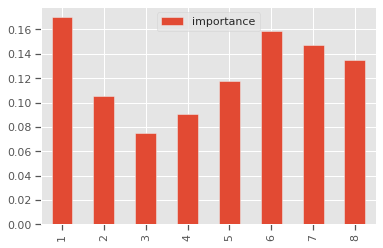

In [20]:
# Feature importances
imp_df = pd.DataFrame({'importance':base_model.feature_importances_},
                      index=range(1, 9),
                     )
imp_df.plot.bar()

## 5. Predict image 3

In [21]:
%%time

area = 3

# With equalisation
im3_df = image_to_sample_df(area, equalise=False)

# Predict image 3
base_preds = base_model.predict(im3_df[cols])

CPU times: user 24 s, sys: 2.81 s, total: 26.9 s
Wall time: 8.93 s


In [22]:
classification_report(im3_df['y'], 
                      base_preds, 
                      class_labels, 
                      class_names,
                     )

Classification report:
                        precision    recall  f1-score   support

           Brown algae       0.68      0.96      0.80   2153112
           Green algae       0.50      0.41      0.45     43001
             Red algae       0.53      0.11      0.19     20030
                  Rock       0.80      0.95      0.87   1931623
                  Sand       0.95      0.50      0.66   1911031
                Lichen       0.37      0.37      0.37      3436
Terrestrial vegetation       0.80      0.81      0.80    459539
         Beach/shingle       0.93      0.37      0.53    546144

              accuracy                           0.77   7067916
             macro avg       0.69      0.56      0.58   7067916
          weighted avg       0.81      0.77      0.75   7067916

Classification accuracy: 0.772822


In [23]:
# With equalisation
im3_df = image_to_sample_df(area, equalise=False, dropna=False)

# Predict image 3
im3_preds = base_model.predict(im3_df[cols])

# Set NoData in predictions
im3_preds[im3_df['y']==0] = 0

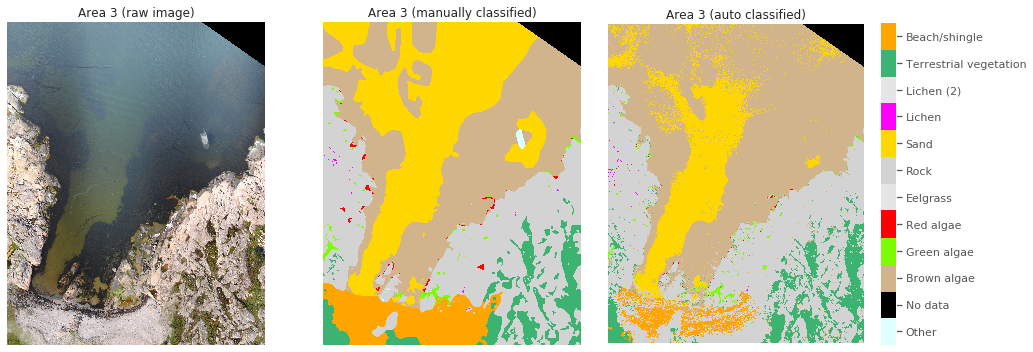

In [24]:
# Paths to images
raw_path = f'/home/jovyan/shared/drones/frisk_oslofjord/raster/ne_akeroya_5cm_area_{area}.tif'
man_path = f'/home/jovyan/shared/drones/frisk_oslofjord/raster/ne_akeroya_5cm_area_{area}_man_class.tif'

# Read raw RGB bands to arrays
band1, ndv, epsg, extent = nivapy.spatial.read_raster(raw_path, band_no=1)
band2, ndv, epsg, extent = nivapy.spatial.read_raster(raw_path, band_no=2)
band3, ndv, epsg, extent = nivapy.spatial.read_raster(raw_path, band_no=3)
raw_img = np.dstack((band1, band2, band3))
    
# Read manual classification
man_img, ndv, epsg, extent = nivapy.spatial.read_raster(man_path, band_no=1)

# Reshape predictions
im3_preds = im3_preds.reshape(man_img.shape)

# Plot
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

# Raw image
axes[0].imshow(raw_img)
axes[0].set_title(f'Area {area} (raw image)', fontsize=12)

# Manually classified
img = axes[1].imshow(man_img, cmap=cmap, norm=norm)
axes[1].set_title(f'Area {area} (manually classified)', fontsize=12)

img = axes[2].imshow(im3_preds, cmap=cmap, norm=norm)
axes[2].set_title(f'Area {area} (auto classified)', fontsize=12)

# Turn off axes
axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')

# Colourbar for manual dataset
cb = plt.colorbar(img, ax=axes[2])    
labels = np.arange(-1, 11)
cb.set_ticks(labels)
cb.set_ticklabels(list(class_codes.values()))
    
plt.tight_layout()

## 6. Train basic model using all images

In [25]:
# Read image data
df_list = []
for area in range(1, 7):
    # With equalisation
    df = image_to_sample_df(area, equalise=False)
    df_list.append(df)
    
df = pd.concat(df_list, axis='rows')
del df_list

print('Number of training samples:  ', len(df))

df.head()

Number of training samples:   49029319


y   1    2    3  4  5  6  7  8
0  1  80  106  121  2  3  3  4  2
1  1  81  108  123  2  3  3  4  2
2  1  76  101  116  2  3  3  4  2
3  1  81  105  121  2  3  3  4  2
4  1  81  105  120  2  3  3  4  2

In [26]:
%%time
# Train basic model
base_model = RandomForestClassifier(n_estimators=10, 
                                    max_depth=20,
                                    random_state=42, 
                                    n_jobs=-1,
                                   )

cols = [str(i) for i in range(1, 9)]
base_model.fit(df[cols], df['y'])

CPU times: user 49min 52s, sys: 29.7 s, total: 50min 22s
Wall time: 9min 3s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

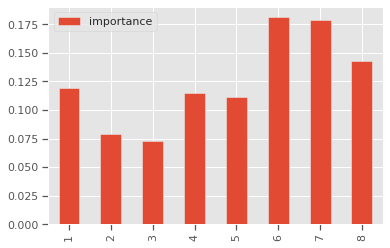

In [27]:
# Feature importances
imp_df = pd.DataFrame({'importance':base_model.feature_importances_},
                      index=range(1, 9),
                     )
imp_df.plot.bar()

In [28]:
out_path = r'/home/jovyan/shared/drones/frisk_oslofjord/base_model.joblib'
dump(base_model, out_path) 

['/home/jovyan/shared/drones/frisk_oslofjord/base_model.joblib']

## 7. Predict "full" image

In [29]:
out_path = r'/home/jovyan/shared/drones/frisk_oslofjord/base_model.joblib'
base_model = load(out_path) 

In [30]:
# Containers for data
data_dict = {}
for band in range(1, 9):
    data_dict[str(band)] = []

# Paths to images
raw_path = f'/home/jovyan/shared/drones/frisk_oslofjord/raster/ne_akeroya_5cm_all.tif'

# Read raw bands to arrays
for band in range(1, 9):
    data, ndv, epsg, extent = nivapy.spatial.read_raster(raw_path, band_no=band)
    #data = img_as_ubyte(exposure.equalize_hist(data))
    data_dict[str(band)].append(data.flatten())
    data_dict[str(band)] = np.concatenate(data_dict[str(band)])

# Build df
df = pd.DataFrame(data_dict)
del(data_dict)

df.reset_index(inplace=True, drop=True)

df.head()

1  2  3  4  5  6  7  8
0  0  0  0  0  0  0  0  0
1  0  0  0  0  0  0  0  0
2  0  0  0  0  0  0  0  0
3  0  0  0  0  0  0  0  0
4  0  0  0  0  0  0  0  0

In [31]:
print(len(df)/1E6)

588.8


In [32]:
%%time

# Predict image 3
cols = [str(i) for i in range(1, 9)]

chunk_res = []
chunks = np.array_split(df, 30)

for chunk in chunks:
    chunk_res.append(base_model.predict(chunk[cols]))
    
all_preds = np.concatenate(chunk_res)

CPU times: user 21min 18s, sys: 3min 25s, total: 24min 44s
Wall time: 5min 51s


In [33]:
# Get snap grid
data, ndv, epsg, extent = nivapy.spatial.read_raster(raw_path, band_no=1)

# Reshape predictions
all_preds = all_preds.reshape(data.shape)

# Set NoData in predictions
all_preds[data==0] = 0

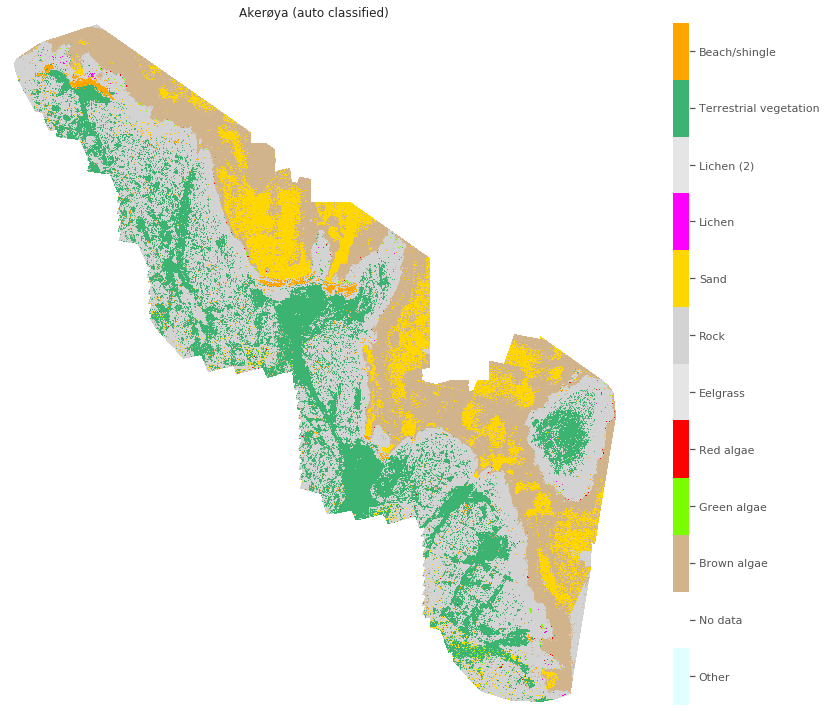

In [34]:
# Class codes
class_codes = {-1:'Other',
               0: 'No data',
               1: 'Brown algae',
               2: 'Green algae',
               3: 'Red algae', 
               4: 'Eelgrass',
               5: 'Rock',
               6: 'Sand',
               7: 'Lichen',
               8: 'Lichen (2)',
               9: 'Terrestrial vegetation',
               10:'Beach/shingle',
              }

# Setup plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10))

# Define colours for classes. Same order as in 'class_codes'
cmap = colors.ListedColormap(['lightcyan', 'white', 'tan', 'lawngreen', 'red', 'none',
                              'lightgrey', 'gold', 'magenta', 'none', 'mediumseagreen', 
                              'orange'])
bounds = np.arange(-1.5, 11.5)
norm = colors.BoundaryNorm(bounds, cmap.N)
   
# Plot  
img = ax.imshow(all_preds, cmap=cmap, norm=norm)
ax.set_title(f'Akerøya (auto classified)', fontsize=12)

# Turn off axes
ax.axis('off')

# Colourbar for manual dataset
cb = plt.colorbar(img, ax=ax, aspect=40)    
labels = np.arange(-1, 11)
cb.set_ticks(labels)
cb.set_ticklabels(list(class_codes.values()))
    
plt.tight_layout()

In [35]:
def array_to_gtiff(xmin, ymax, cell_size, out_path, data_array,
                   proj4_str, no_data_value=-9999, flip=False,
                   bit_depth='Float32', compress=True):
    """ Save numpy array as a single band GeoTiff (in a projected
        co-ordinate system).
    
    Args:
        xmin:          Int. Minimum x value in metres
        ymax:          Int. Maximum y value in metres
        cell_size:     Int. Grid cell size in metres
        out_path:      Raw str. Path to GeoTiff
        data:          Array. Array to save 
        proj4_str      Str. proj.4 string defining the projection
        no_data_value: Int. Value to use to represent no data
        flip:          Bool. Whether to flip the array. Sometime seems
                       to be necessary. Further investigation needed
        bit_depth:     Str. Specify bit depth. Choosing wisely can dramatically 
                       reduce file sizes, but beware of numerical 
                       over/underflow. Must be one of the following strings:

                           ('Byte', 'Int16', 'UInt16', 'UInt32', 
                            'Int32', 'Float32', 'Float64')

        compress:      Bool. Whether to use LZW compression to reduce the size 
                       of the saved grid. Can dramatically reduce file sizes,
                       but adds processing overhead for compression and 
                       decompression
        
    Returns:
        None. Array is saved to specified path.
    """
    # Import modules
    from osgeo import gdal, gdalconst, osr
    import numpy as np

    # Check and get bit depth
    bit_depth_dict = {'Byte':gdal.GDT_Byte, 
                      'Int16':gdal.GDT_Int16,
                      'UInt16':gdal.GDT_UInt16,
                      'UInt32':gdal.GDT_UInt32,
                      'Int32':gdal.GDT_Int32,
                      'Float32':gdal.GDT_Float32,
                      'Float64':gdal.GDT_Float64,
                      }

    assert bit_depth in bit_depth_dict.keys(), "'bit_depth' must be one of %s" % list(bit_depth_dict.keys())
    bit_depth = bit_depth_dict[bit_depth]

    # Explicitly set NDV
    #data_array[np.isnan(data_array)] = no_data_value
    
    # Flip. Not sure why this is necessary? Without it the 
    # output grid is upside down! Haven't had this problem before,
    # but this seems to work here. Beware in future!
    if flip:
        data_array = data_array[::-1,:]

    # Get array shape
    cols = data_array.shape[1]
    rows = data_array.shape[0]

    # Get driver
    driver = gdal.GetDriverByName('GTiff')

    # Create a new raster data source
    if compress:
        out_ds = driver.Create(out_path, cols, rows, 1, bit_depth,
                               options=['COMPRESS=LZW'])
    else:
        out_ds = driver.Create(out_path, cols, rows, 1, bit_depth)      

    # Get spatial reference
    sr = osr.SpatialReference()
    sr.ImportFromProj4(proj4_str)
    sr_wkt = sr.ExportToWkt()

    # Write metadata
    # (xmin, cellsize, 0, ymax, 0, -cellsize)
    out_ds.SetGeoTransform((int(xmin), cell_size, 0.0, 
                            int(ymax), 0.0, -cell_size))  
    out_ds.SetProjection(sr_wkt)
    out_band = out_ds.GetRasterBand(1)
    out_band.SetNoDataValue(no_data_value)
    out_band.WriteArray(data_array)

    # Tidy up
    del out_ds, out_band

In [36]:
out_path = f'/home/jovyan/shared/drones/frisk_oslofjord/raster/ne_akeroya_5cm_all_auto_class.tif'
array_to_gtiff(extent[0],
               extent[-1],
               0.05,
               out_path,
               all_preds,
               '+proj=utm +zone=32 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs',
               0,
               bit_depth='Int16')